# Import libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import json

import cv2
from torchvision.datasets import ImageFolder
import os

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import sys

import torch.optim as optim
import time

import pandas as pd 

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from PIL import Image, ImageOps
import random

from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

from scipy.optimize import minimize
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction
from bayes_opt import SequentialDomainReductionTransformer

# Functions to select a subset of given images and convert them to common resolution and square proportions.
### Original images come in various resolutions and proportions, and we need to unify them for use by CNN. If a given picture is of different aspect ratio, its background will be filled with its backgrond color to fill the square.

In [2]:
def resize_and_pad(image, file_path, target_res = 120):
    
    target_size = (target_res, target_res)
    old_size = image.size

    # Compute the scaling factor to maintain the aspect ratio
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])

    # Compute the new size with the same aspect ratio
    new_size = (int(old_size[0] * ratio), int(old_size[1] * ratio))

    # Resize the image while preserving the aspect ratio
    image_resized = image.resize(new_size, Image.ANTIALIAS)

    # Create a new blank image with the target size and fill it with black
    first_pixel_color = image.getpixel((image.width-2, image.height-2))
    new_image = Image.new("RGB", target_size, first_pixel_color)

    # Paste the resized image in the center of the new image
    offset = ((target_size[0] - new_size[0]) // 2, (target_size[1] - new_size[1]) // 2)
    new_image.paste(image_resized, offset)

    # separate path from file name
    folder_name, file_name = os.path.split(file_path)
    
    # extract just the folder name
    _, folder_name = os.path.split(folder_name)

    # Create the output file path with the original folder and file name
    output_file_path = os.path.join(output_dir, folder_name, file_name)

    return new_image, output_file_path

def IterateDataSet(selectImages = [500, 500, 400, 400], target_res = 120):
    
    # check number of files in each cancer folder
    folderFiles = {}
    for i, (image, label) in enumerate(dataset):

        file_path = dataset.imgs[i][0]

        # separate path from file name
        folder_name, file_name = os.path.split(file_path)
    
        # extract just the folder name
        _, cancerName = os.path.split(folder_name)

        if cancerName in folderFiles:
            folderFiles[cancerName] += 1
        else:
            folderFiles[cancerName] = 1
            
    # randomly select image indices from the available
    lowerBound = 0
    cancerIndices = []
    for (i, key) in enumerate(folderFiles):
        upperBound = lowerBound + folderFiles[key]
        print(key + ": randomly picking " + str(selectImages[i]) + " from " + str(folderFiles[key]))
        cancerIndices += random.sample(range(lowerBound, upperBound), selectImages[i])
        lowerBound = upperBound


    # iterate throught the data set and resize images that where randomly selected
    for i, (image, label) in enumerate(dataset):
            
        if i not in cancerIndices:
            continue
            
        # Get the original file path of the image
        file_path = dataset.imgs[i][0]
        
        # Resize and pad the image, and get the output file path
        new_image, output_file_path = resize_and_pad(image, file_path, target_res)

        # Create the output directory for the current image's folder (if it doesn't exist)
        output_folder = os.path.dirname(output_file_path)
        
        os.makedirs(output_folder, exist_ok=True)

        #print(output_file_path)
        # Save the resized and padded image
        new_image.save(output_file_path)

    print("Images resized and saved.")

# Resize training images for BO and save them to a separate folder. Also, resize training images for full final training and save to a another folder.

In [3]:
################################################################################################
# specify the root folder and target folder for training data set
root = r'.\brains\Training'
output_dir = r'.\brains\Training_BO'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the ImageFolder dataset and apply the transformation
dataset = ImageFolder(root=root)

# do data boosting:
# pick 500 images each from glioma and meningiona, and 400 images each from notumor and pituitary
# because glioma and meningioma are the most difficult to recognise
IterateDataSet([600, 600, 400, 400], 120);


################################################################################################
# specify the root folder and target folder for training data set
root = r'.\brains\Training'
output_dir = r'.\brains\Training_FINAL'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the ImageFolder dataset and apply the transformation
dataset = ImageFolder(root=root)

# do data boosting:
# pick 1300 images each from glioma and meningiona, and 1100 images each from notumor and pituitary
# because glioma and meningioma are the most difficult to recognise
IterateDataSet([1300, 1300, 1100, 1100], 120);

glioma: randomly picking 600 from 1321
meningioma: randomly picking 600 from 1339
notumor: randomly picking 400 from 1595
pituitary: randomly picking 400 from 1457


C:\Users\rafae\AppData\Local\Temp\ipykernel_11304\627784165.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image_resized = image.resize(new_size, Image.ANTIALIAS)


Images resized and saved.
glioma: randomly picking 1300 from 1321
meningioma: randomly picking 1300 from 1339
notumor: randomly picking 1100 from 1595
pituitary: randomly picking 1100 from 1457
Images resized and saved.


# Resize test set images for BO and save them to a separate folder. Also, resize test set images for full final testing and save to another folder.

In [4]:
################################################################################################
# Set the output directory for the resized images
root = r'.\brains\Testing'
output_dir = r'.\brains\Testing_BO'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the ImageFolder dataset and apply the transformation
dataset = ImageFolder(root=root)

# no need for data boosting, we can keep all classes in equal proportions
IterateDataSet([100, 100, 100, 100], 120);


################################################################################################
# Set the output directory for the resized images
root = r'.\brains\Testing'
output_dir = r'.\brains\Testing_FINAL'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the ImageFolder dataset and apply the transformation
dataset = ImageFolder(root=root)

# no need for data boosting, we can keep all classes in equal proportions
IterateDataSet([300, 300, 300, 300], 120);

glioma: randomly picking 100 from 300
meningioma: randomly picking 100 from 306
notumor: randomly picking 100 from 405
pituitary: randomly picking 100 from 300


C:\Users\rafae\AppData\Local\Temp\ipykernel_11304\627784165.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image_resized = image.resize(new_size, Image.ANTIALIAS)


Images resized and saved.
glioma: randomly picking 300 from 300
meningioma: randomly picking 300 from 306
notumor: randomly picking 300 from 405
pituitary: randomly picking 300 from 300
Images resized and saved.


# Useful functions used for loading and showing data

In [5]:
def img_loader(filename):
    return cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

def imshow(img):
    npimg = img.numpy()
    
    # convert from (channel, w, h) to (w, h, channel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def SampleTestRaw(dataLoader, classes):
    dataiter = iter(dataLoader)
    images, labels = next(dataiter)

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))
    

# Classes used in this study

In [6]:
allClasses = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Load the training data for BO

['glioma', 'meningioma', 'notumor', 'pituitary']
Training data length: 2000


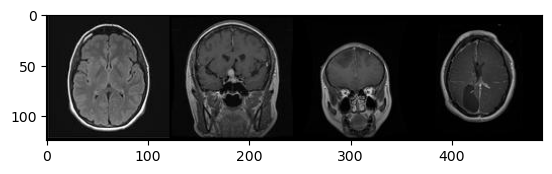

GroundTruth:  notumor pituitary glioma glioma


In [7]:
batchSize = 4

# will not use batching in this case, as it removed important features and makes learning less effective
transform = transforms.Compose(
    [transforms.ToTensor()])

# load training data:
######################
trainData = ImageFolder(root='./brains/Training_BO', loader=img_loader, transform=transform)
print(trainData.classes)
print("Training data length: " + str(len(trainData)))

trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize, shuffle=True)
trainData = []
for image, label in trainLoader:
    trainData.append((image, label))

# show some
SampleTestRaw(trainData, allClasses)

# Load the test data for BO

['glioma', 'meningioma', 'notumor', 'pituitary']
Test data length: 400


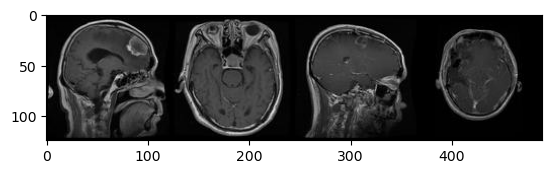

GroundTruth:  meningioma pituitary glioma glioma


In [8]:
# load testing data:
######################
testData = ImageFolder(root='./brains/Testing_BO', loader=img_loader, transform=transform)
print(testData.classes)
print("Test data length: " + str(len(testData)))

testLoader = torch.utils.data.DataLoader(testData, batch_size=batchSize, shuffle=True)
testData = []
for image, label in testLoader:
    testData.append((image, label))

# show some
SampleTestRaw(testData, allClasses)

# A bunch of useful testing functions in this cell.

In [9]:
def SampleTestTrained(net, test_loader, classes):
    dataiter = iter(test_loader)
    images, labels = next(dataiter)

    # print images
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))
    
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(len(labels))))
    print(' ')

    
def OverallAccuracy(net, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %d %%' % (total , 100 * correct / total))
    print(' ')
    return 100 * correct / total

    
def ClassFinder(net, test_loader, classes):
    
    trueValues = []
    predictedValues = []
    
    # iterate over all the data in batches
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)

            # iterate over the batch and record the classes (strings)
            for i in range(labels.numel()):
                trueValues.append(classes[labels[i]])
                predictedValues.append(classes[predicted[i]])

    # record unique classes
    unique_classes = (np.unique(trueValues)).tolist()
    
    # prepare the same lists for columns and rows of the confusion matrix
    rows = list(unique_classes)
    cols = list(unique_classes)
    countedTrue = []
    countedPred = []
    
    # build lists used later for confusion matrix
    for i in range(len(unique_classes)):
        rows[i] = str(rows[i]+'_true')
        cols[i] = str(cols[i]+'_pred')
        countedTrue.append([unique_classes[i], trueValues.count(unique_classes[i])])
        countedPred.append([unique_classes[i], predictedValues.count(unique_classes[i])])

    # build the confusion matrix
    cm = confusion_matrix(trueValues, predictedValues, labels=unique_classes)
    confusion_df = pd.DataFrame(cm, index=rows, columns=cols)
    print(confusion_df)
    print(' ')
    
def TestAllClasses(net, test_loader, classes):
        
    class_correct = [0. for i in range(len(classes))]
    class_total = [0. for i in range(len(classes))]
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            if(c.numel() == 1):
                i = 0
                label = labels[i]
                class_correct[label] += c.item()
                class_total[label] += 1
                continue
            for i in range(c.numel()):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(len(classes)):
        print('Accuracy of %5s : %4d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

# Functions used to save and laod the past points and observations.

In [10]:
def SaveX(pastPoints):

    # File path to save the dictionary
    file_path = 'x_dict.json'

    # Save the dictionary to the file using json.dump()
    with open(file_path, 'w') as f:
        json.dump(pastPoints, f)

        
def LoadX():

    # File path from which to load the dictionary
    file_path = 'x_dict.json'

    # Load the dictionary from the file using json.load()
    with open(file_path, 'r') as f:
        loaded_dict = json.load(f)

    print('Loaded x list size: ' + str(len(loaded_dict)))
    
    return loaded_dict


def SaveY(pastYs):

    # File path to save the list
    file_path = 'y_list.json'

    # Save the list to the file using json.dump()
    with open(file_path, 'w') as f:
        json.dump(pastYs, f)

        
def LoadY():

    # File path from which to load the list
    file_path = 'y_list.json'

    # Load the list from the file using json.load()
    with open(file_path, 'r') as f:
        loaded_y = json.load(f)

    print('Loaded y list size: ' + str(len(loaded_y)))
    
    return loaded_y

# This is the CNN class definition

In [11]:
class BrainNet(nn.Module):
    def __init__(self, name=None, newParams = None, product = 1):
        super(BrainNet, self).__init__()
        
        if name:
            self.name = name
            
        # sample values in order:
        '''
        conv1_maps = 8
        conv1_kernel = 5

        conv2_maps = 24
        conv2_kernel = 4

        conv3_maps = 32
        conv3_kernel = 4

        fully_conn1 = 120
        fully_conn2 = 84
        
        dropout = 0
        maxpool = 2
        '''
        
        # this is used to pass the product at the end of convolutional nets, e.g. 26*27*27
        self.product = product
        
        # Convolutional layers
        self.pool = nn.MaxPool2d(newParams.maxpool, newParams.maxpool)

        self.conv1 = nn.Conv2d(1, newParams.conv1_maps, newParams.conv1_kernel)
        self.bn1 = nn.BatchNorm2d(newParams.conv1_maps)
        
        self.conv2 = nn.Conv2d(newParams.conv1_maps, newParams.conv2_maps, newParams.conv2_kernel)
        self.bn2 = nn.BatchNorm2d(newParams.conv2_maps)
        
        self.conv3 = nn.Conv2d(newParams.conv2_maps, newParams.conv3_maps, newParams.conv3_kernel)
        self.bn3 = nn.BatchNorm2d(newParams.conv3_maps)
        
        # Fully connected layers
        self.fc1 = nn.Linear(product, newParams.fully_conn1)
        self.fc2 = nn.Linear(newParams.fully_conn1, newParams.fully_conn2)
        self.dropout = nn.Dropout(p=newParams.dropout) # Dropout
        self.fc3 = nn.Linear(newParams.fully_conn2, 4)

        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        # if product is 1, then this call was made by fake net - do not print anything, it's irrelevant
        if product != 1:
            print(self.name + ': total params:', total_params)

    def forward(self, x, getShape = False):
        x = self.bn1(F.relu(self.pool(self.conv1(x))))
        x = self.bn2(F.relu(self.pool(self.conv2(x))))
        x = self.bn3(F.relu(self.pool(self.conv3(x))))

        # used only by fake net to get the shape of x vector automatically
        if getShape: 
            return x.shape
        
        x = x.view(-1, self.product)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x))) # Added dropout
        x = self.fc3(x)

        return x

In [12]:
def train(net, train_loader, epochs = 5):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)#, momentum=0.90)

    start = time.time()

    # loop over the dataset multiple times
    for epoch in range(epochs):

        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
        
            # take the data from the batch
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 10 mini-batches
                print('[%d, %5d] loss: %.5f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

    end = time.time()
    print('training time ', end-start)

# This is a struct that encapsulates the hyperparameters - it is later fed into the BrainNet class.

In [13]:
class NetParams:
    def __init__(self, conv1_maps, conv1_kernel, 
                 conv2_maps, conv2_kernel, 
                 conv3_maps, conv3_kernel, 
                 fully_conn1, fully_conn2,
                 dropout = 0, maxpool = 2):
        
        self.conv1_maps = conv1_maps
        self.conv1_kernel = conv1_kernel
        self.conv2_maps = conv2_maps
        self.conv2_kernel = conv2_kernel
        self.conv3_maps = conv3_maps
        self.conv3_kernel = conv2_kernel
        self.fully_conn1 = fully_conn1
        self.fully_conn2 = fully_conn2
        self.dropout = dropout
        self.maxpool = maxpool

# This is called either by BO or manaully to start CNN training.

In [18]:
def StartOptimising(newParamss, train_loader, test_loader, all_classes, epochs = 5):
    
    # initialise fake net that will be used to pick the value of the product
    fakeNet = BrainNet(name='LetNet5', newParams = newParamss)
    
    # initialise the product variable
    product = 1
    
    # run 1 iteration of pseudo-learning to receive the shape of x vector and compute the product
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        shapes = fakeNet(inputs, True)
        product = shapes[1] * shapes[2] * shapes[3]
        break
    
    # now the real net
    net = BrainNet(name='LetNet5', newParams = newParamss, product = product)
    train(net, train_loader, epochs)
    
    # set the model to testing, which disables the dropout
    net.eval()

    SampleTestTrained(net, test_loader, all_classes)
    ClassFinder(net, test_loader, all_classes)
    TestAllClasses(net, test_loader, all_classes)
    
    return OverallAccuracy(net, test_loader)

# Just a manual training and testing call, can be used for manual tuning

LetNet5: total params: 500894
[1,   100] loss: 1.05405
[1,   200] loss: 0.81048
[1,   300] loss: 0.72393
[1,   400] loss: 0.57198
[1,   500] loss: 0.54719
[2,   100] loss: 0.38706
[2,   200] loss: 0.53868
[2,   300] loss: 0.38622
[2,   400] loss: 0.50631
[2,   500] loss: 0.42645
[3,   100] loss: 0.29125
[3,   200] loss: 0.33603
[3,   300] loss: 0.26818
[3,   400] loss: 0.26289
[3,   500] loss: 0.28057
[4,   100] loss: 0.16474
[4,   200] loss: 0.16668
[4,   300] loss: 0.22705
[4,   400] loss: 0.21614
[4,   500] loss: 0.21304
[5,   100] loss: 0.16539
[5,   200] loss: 0.20429
[5,   300] loss: 0.16116
[5,   400] loss: 0.23293
[5,   500] loss: 0.23261
Finished Training
training time  62.08857011795044


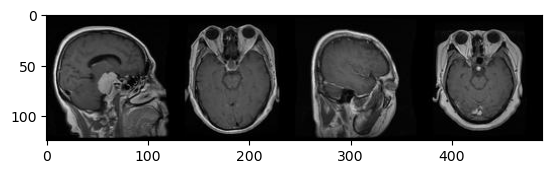

GroundTruth:  meningioma pituitary glioma pituitary
Predicted:  meningioma pituitary glioma pituitary
 
                 glioma_pred  meningioma_pred  notumor_pred  pituitary_pred
glioma_true               88               12             0               0
meningioma_true           10               72            12               6
notumor_true               1                6            93               0
pituitary_true             2                2             0              96
 
Accuracy of glioma :   88 %
Accuracy of meningioma :   72 %
Accuracy of notumor :   93 %
Accuracy of pituitary :   96 %
Accuracy of the network on the 400 test images: 87 %
 


In [19]:
# example values in order:
'''
conv1_maps = 8
conv1_kernel = 5

conv2_maps = 24
conv2_kernel = 4

conv3_maps = 32
conv3_kernel = 4

fully_conn1 = 120
fully_conn2 = 84

dropout = 0
maxpool = 2
'''

newParams = NetParams(14, 3, 22, 5, 32, 3, 120, 84, 0, 2)
epochs = 5
y = StartOptimising(newParams, trainLoader, testLoader, allClasses, epochs)

## Run this cell to start BO optimisation. Note that to reduce dropout-induced stochasticity which can affect the optimisation, dropout it has been set to 0, and will be determined later. Also, the maxpool parameter is not optimised here and set to 2, as the total number of hyperparameters to optimise in BO would be getting too big.

x rounded:
[13, 4, 21, 2, 31, 3, 106, 70]
LetNet5: total params: 567313
[1,   100] loss: 0.93445
[1,   200] loss: 0.72967
[1,   300] loss: 0.64942
[1,   400] loss: 0.51803
[1,   500] loss: 0.57557
[2,   100] loss: 0.38004
[2,   200] loss: 0.37995
[2,   300] loss: 0.37593
[2,   400] loss: 0.30478
[2,   500] loss: 0.36307
[3,   100] loss: 0.23069
[3,   200] loss: 0.17188
[3,   300] loss: 0.20323
[3,   400] loss: 0.21902
[3,   500] loss: 0.19844
[4,   100] loss: 0.09285
[4,   200] loss: 0.14155
[4,   300] loss: 0.12103
[4,   400] loss: 0.10308
[4,   500] loss: 0.19580
[5,   100] loss: 0.12040
[5,   200] loss: 0.05650
[5,   300] loss: 0.09134
[5,   400] loss: 0.04316
[5,   500] loss: 0.12380
Finished Training
training time  63.23532700538635


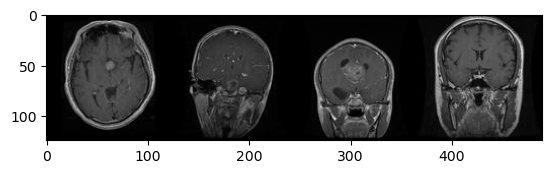

GroundTruth:  pituitary glioma glioma pituitary
Predicted:  pituitary glioma glioma pituitary
 
                 glioma_pred  meningioma_pred  notumor_pred  pituitary_pred
glioma_true               80               15             0               5
meningioma_true            7               82             8               3
notumor_true               1                5            93               1
pituitary_true             1                6             0              93
 
Accuracy of glioma :   80 %
Accuracy of meningioma :   82 %
Accuracy of notumor :   93 %
Accuracy of pituitary :   93 %
Accuracy of the network on the 400 test images: 87 %
 
y max is 87.0
x rounded:
[16, 6, 21, 6, 37, 5, 111, 81]
LetNet5: total params: 461077
[1,   100] loss: 1.03182
[1,   200] loss: 0.79208
[1,   300] loss: 0.67857
[1,   400] loss: 0.61067
[1,   500] loss: 0.67931
[2,   100] loss: 0.43416
[2,   200] loss: 0.54861
[2,   300] loss: 0.44559
[2,   400] loss: 0.44274
[2,   500] loss: 0.41871
[3,   100] 

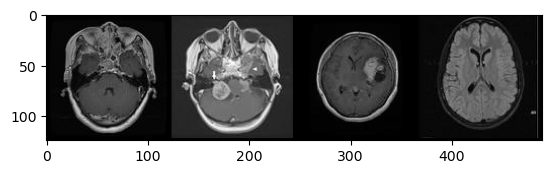

GroundTruth:  pituitary meningioma meningioma notumor
Predicted:  pituitary meningioma meningioma notumor
 
                 glioma_pred  meningioma_pred  notumor_pred  pituitary_pred
glioma_true               79               21             0               0
meningioma_true            2               90             5               3
notumor_true               2               10            88               0
pituitary_true             1                6             0              93
 
Accuracy of glioma :   79 %
Accuracy of meningioma :   90 %
Accuracy of notumor :   88 %
Accuracy of pituitary :   93 %
Accuracy of the network on the 400 test images: 87 %
 
y max is 87.5
x rounded:
[8, 5, 22, 3, 35, 6, 116, 88]
LetNet5: total params: 705817
[1,   100] loss: 0.94350
[1,   200] loss: 0.78413
[1,   300] loss: 0.67654
[1,   400] loss: 0.63742
[1,   500] loss: 0.49718
[2,   100] loss: 0.41770
[2,   200] loss: 0.35232
[2,   300] loss: 0.37487
[2,   400] loss: 0.31213
[2,   500] loss: 0.36278


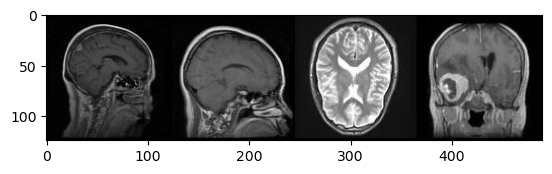

GroundTruth:  meningioma pituitary notumor meningioma
Predicted:  glioma pituitary notumor pituitary
 
                 glioma_pred  meningioma_pred  notumor_pred  pituitary_pred
glioma_true               89               10             0               1
meningioma_true           14               73             8               5
notumor_true               3                1            95               1
pituitary_true             2                1             0              97
 
Accuracy of glioma :   89 %
Accuracy of meningioma :   73 %
Accuracy of notumor :   95 %
Accuracy of pituitary :   97 %
Accuracy of the network on the 400 test images: 88 %
 
y max is 88.5


In [20]:
pbounds = {
           'conv1_maps': (6,16), 
           'conv1_kernel': (2, 6),
           'conv2_maps': (18,28), 
           'conv2_kernel': (2, 6),
           'conv3_maps': (30,38), 
           'conv3_kernel': (2, 6),
           'fully_conn1': (100, 130),
           'fully_conn2': (60, 90)
           }

optimizer = BayesianOptimization(
    f=None,
    pbounds=pbounds,
    verbose=1,
    random_state=1,
)


# train on the query-observation points
def trainTheModel(x_list, y_list):
    for i in range(len(x_list)):
        optimizer.register(params=x_list[i], target=y_list[i])
        
        
# lists to store the points used and their observations
pastX = []
pastY = []

## load the past points
#pastX = LoadX()
#pastY = LoadY()
#trainTheModel(pastX, pastY)

# define acquisition function
utility = UtilityFunction(kind="ucb", kappa=0.96)

optimizer.probe(
    params={"conv1_maps": 14, "conv1_kernel": 3,
            "conv2_maps": 22, "conv2_kernel": 5,
            "conv3_maps": 32, "conv3_kernel": 3,
            "fully_conn1": 120,"fully_conn2": 84},
    lazy=True,
)

# set to 20 iterations
counter = 20
while counter > 0:
    
    next_point_to_probe = optimizer.suggest(utility)
    x = next_point_to_probe

    #print('origianlPredictions:')
    floatList = [x['conv1_maps'], x['conv1_kernel'],
                 x['conv2_maps'], x['conv2_kernel'], 
                 x['conv3_maps'], x['conv3_kernel'], 
                 x['fully_conn1'], x['fully_conn2']]
    #print(floatList)

    x['conv1_maps'] = round(x['conv1_maps'])
    x['conv1_kernel'] = round(x['conv1_kernel'])
    x['conv2_maps'] = round(x['conv2_maps'])
    x['conv2_kernel'] = round(x['conv2_kernel'])
    x['conv3_maps'] = round(x['conv3_maps'])
    x['conv3_kernel'] = round(x['conv3_kernel'])
    x['fully_conn1'] = round(x['fully_conn1'])
    x['fully_conn2'] = round(x['fully_conn2'])

    intList =   [x['conv1_maps'], x['conv1_kernel'],
                 x['conv2_maps'], x['conv2_kernel'], 
                 x['conv3_maps'], x['conv3_kernel'], 
                 x['fully_conn1'], x['fully_conn2']]
    
    if x not in pastX:
        print('x rounded:')
        print(intList)
        newParams = NetParams(x['conv1_maps'], x['conv1_kernel'], 
                              x['conv2_maps'], x['conv2_kernel'], 
                              x['conv3_maps'], x['conv3_kernel'], 
                              x['fully_conn1'], x['fully_conn2'])
        
        y = StartOptimising(newParams, trainLoader, testLoader, allClasses, 5)
        
        pastX.append(x)
        pastY.append(y)

        optimizer.register(x, y)
        print("y max is", optimizer.max['target'])
        
        counter -= 1
    else:
        continue
        
# save the points so that we can resume later without losing the observations already made
SaveX(pastX)
SaveY(pastY)


# Once the BO has been run (preferrably a few times with decreasing values of kappa), in this final part we'll load all BO points and observations and pick the hyperparameters that gave the best overall accuracy.

# Load the full data from folders - we'll perform more in-depth training, using the hyperparameters found above.

Training data length: 4800


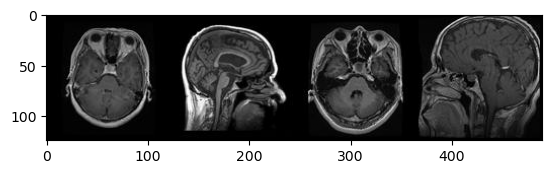

GroundTruth:  pituitary notumor pituitary pituitary


Test data length: 1200


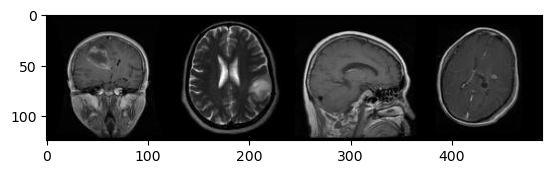

GroundTruth:  glioma notumor pituitary glioma


In [21]:
batchSize = 4

# will not use batching in this case, as it removed important features and makes learning less effective
transform = transforms.Compose(
    [transforms.ToTensor()])

# load training data:
######################
trainDataFinal = ImageFolder(root='./brains/Training_FINAL', loader=img_loader, transform=transform)
print("Training data length: " + str(len(trainDataFinal)))

trainLoaderFinal = torch.utils.data.DataLoader(trainDataFinal, batch_size=batchSize, shuffle=True)
trainDataFinal = []
for image, label in trainLoaderFinal:
    trainDataFinal.append((image, label))

# show some
SampleTestRaw(trainDataFinal, allClasses)



# load testing data:
######################
testDataFinal = ImageFolder(root='./brains/Testing_FINAL', loader=img_loader, transform=transform)
print("\n\nTest data length: " + str(len(testDataFinal)))

testLoaderFinal = torch.utils.data.DataLoader(testDataFinal, batch_size=batchSize, shuffle=True)
testDataFinal = []
for image, label in testLoaderFinal:
    testDataFinal.append((image, label))

# show some
SampleTestRaw(testDataFinal, allClasses)

In [22]:
def SortListByList(a, b):
    
    a_s = sorted(a)
    a2 = list(a)
    b_s = []
    
    for i in a_s:
        b_s.append(b[a2.index(i)])
        a2[a.index(i)] = -1
        
    return a_s, b_s

# load the points from .json file
loaded_y = LoadY()
loaded_x = LoadX()

# sort both lists by asceding y
sorted_y, sorted_x = SortListByList(loaded_y, loaded_x)

# show best point
print(sorted_y[-1])
print(sorted_x[-1])
bestX = sorted_x[-1]

Loaded y list size: 3
Loaded x list size: 3
88.5
{'conv1_kernel': 5, 'conv1_maps': 8, 'conv2_kernel': 3, 'conv2_maps': 22, 'conv3_kernel': 6, 'conv3_maps': 35, 'fully_conn1': 116, 'fully_conn2': 88}


LetNet5: total params: 705817
[1,   100] loss: 1.05247
[1,   200] loss: 0.77829
[1,   300] loss: 0.68138
[1,   400] loss: 0.71056
[1,   500] loss: 0.51297
[1,   600] loss: 0.46835
[1,   700] loss: 0.49100
[1,   800] loss: 0.41807
[1,   900] loss: 0.42760
[1,  1000] loss: 0.40371
[1,  1100] loss: 0.42291
[1,  1200] loss: 0.33321
[2,   100] loss: 0.28782
[2,   200] loss: 0.26574
[2,   300] loss: 0.28221
[2,   400] loss: 0.25901
[2,   500] loss: 0.29495
[2,   600] loss: 0.27625
[2,   700] loss: 0.32775
[2,   800] loss: 0.31503
[2,   900] loss: 0.32276
[2,  1000] loss: 0.27391
[2,  1100] loss: 0.25967
[2,  1200] loss: 0.30717
[3,   100] loss: 0.11868
[3,   200] loss: 0.17068
[3,   300] loss: 0.25187
[3,   400] loss: 0.20000
[3,   500] loss: 0.29038
[3,   600] loss: 0.24715
[3,   700] loss: 0.21540
[3,   800] loss: 0.28278
[3,   900] loss: 0.24863
[3,  1000] loss: 0.26472
[3,  1100] loss: 0.17683
[3,  1200] loss: 0.19044
[4,   100] loss: 0.15029
[4,   200] loss: 0.11453
[4,   300] loss: 0.1

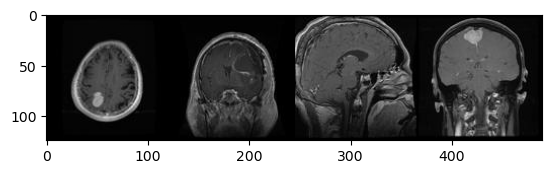

GroundTruth:  meningioma glioma pituitary meningioma
Predicted:  meningioma glioma pituitary meningioma
 
                 glioma_pred  meningioma_pred  notumor_pred  pituitary_pred
glioma_true              279               20             1               0
meningioma_true           38              188            70               4
notumor_true               1                0           299               0
pituitary_true             1                2            17             280
 
Accuracy of glioma :   93 %
Accuracy of meningioma :   62 %
Accuracy of notumor :   99 %
Accuracy of pituitary :   93 %
Accuracy of the network on the 1200 test images: 87 %
 


In [23]:
dropout = 0.2
newParams = NetParams(bestX['conv1_maps'], bestX['conv1_kernel'], 
                      bestX['conv2_maps'], bestX['conv2_kernel'], 
                      bestX['conv3_maps'], bestX['conv3_kernel'], 
                      bestX['fully_conn1'], bestX['fully_conn2'], dropout)
epochs = 25
y = StartOptimising(newParams, trainLoaderFinal, testLoaderFinal, allClasses, epochs)